 # scaled_harris_and_zernike_development 
## Setup the required functions and input images

In [109]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb  1 20:06:06 2019

@author: vik748
"""
import numpy as np
import cv2
import sys
from matplotlib import pyplot as plt
from ssc import *
%matplotlib inline
from scipy import spatial
import time
np.set_printoptions(precision=4,suppress=True)

#from mahotas import features

def draw_keypoints(vis_orig, keypoints, color = (255, 255, 0), thick = 1):
    vis = vis_orig.copy()
    for kp in keypoints:
        x, y = kp.pt
        cv2.circle(vis, (int(x), int(y)), int(vis.shape[1]/200), color, thickness=thick)
    return vis

def draw_markers(vis_orig, keypoints, color = (0, 0, 255)):
    vis = vis_orig.copy()
    for kp in keypoints:
        x, y = kp.pt
        cv2.drawMarker(vis, (int(x), int(y)), color,  markerSize=30, markerType = cv2.MARKER_CROSS, thickness=3)
    return vis

def draw_marker_pts(vis_orig, pts, color = (255, 255, 0),markerSize=30):
    vis = cv2.cvtColor(vis_orig,cv2.COLOR_GRAY2RGB)
    for row in pts[:,0,:]:
        cv2.drawMarker(vis, (int(row[0]), int(row[1])), color,  markerSize=markerSize, markerType = cv2.MARKER_CROSS, thickness=1)
    return vis

def draw_arrows(vis_orig, points1, points2, color = (0, 255, 0), thick = 1):
    vis = cv2.cvtColor(vis_orig,cv2.COLOR_GRAY2RGB)
    #rad = int(vis.shape[1]/200)
    for p1,p2 in zip(points1,points2):
        cv2.arrowedLine(vis, (int(p1[0]),int(p1[1])), (int(p2[0]),int(p2[1])), color=(0,255,0), thickness=thick)
    return vis

def draw_feature_tracks(img_left,kp1,img_right,kp2, matches, mask, display_invalid=False, color=(0, 255, 0)):
    '''
    This function extracts takes a 2 images, set of keypoints and a mask of valid
    (mask as a ndarray) keypoints and plots the valid ones in green and invalid in red.
    The mask should be the same length as matches
    '''
    if mask is None: bool_mask = np.ones((len(matches)), dtype=bool)
    else: bool_mask = mask.astype(bool)
    valid_right_matches = np.array([kp2[mat.trainIdx].pt for is_match, mat in zip(bool_mask, matches) if is_match])
    valid_left_matches = np.array([kp1[mat.queryIdx].pt for is_match, mat in zip(bool_mask, matches) if is_match])
    #img_right_out = draw_points(img_right, valid_right_matches)
    img_right_out = draw_arrows(img_right, valid_left_matches, valid_right_matches)
    return img_right_out

def displayMatches(img_left,kp1,img_right,kp2, matches, mask, display_invalid, in_image=None, color=(0, 255, 0)):
    '''
    This function extracts takes a 2 images, set of keypoints and a mask of valid
    (mask as a ndarray) keypoints and plots the valid ones in green and invalid in red.
    The mask should be the same length as matches
    '''
    bool_mask = mask.astype(bool)
    if in_image is None: mode_flag=0
    else: mode_flag =1
    img_valid = cv2.drawMatches(img_left,kp1,img_right,kp2,matches, in_image, 
                                matchColor=color, 
                                matchesMask=bool_mask.ravel().tolist(), flags=mode_flag)
    
    if display_invalid:
        img_valid = cv2.drawMatches(img_left,kp1,img_right,kp2,matches, img_valid, 
                                  matchColor=(255, 0, 0), 
                                  matchesMask=np.invert(bool_mask).ravel().tolist(), 
                                  flags=1)
    return img_valid


K = np.array([[699.33112889, 0.0, 403.23876197],
              [0.0, 693.66457792, 293.40739086],
              [0.0, 0.0, 1.0]])

D =  np.array([-2.78089511e-01,  1.30037134e-01, -1.17555797e-04, -1.55337290e-04, -4.34486330e-02])

if sys.platform == 'darwin':
    path = '/Users/vik748/Google Drive/'
else:
    path = '/home/vik748/'
img1 = cv2.imread(path+'data/time_lapse_5_cervino_800x600/G0057821.png',1) # iscolor = CV_LOAD_IMAGE_GRAYSCALE
img2 = cv2.imread(path+'data/time_lapse_5_cervino_800x600/G0057826.png',1) # iscolor = CV_LOAD_IMAGE_GRAYSCALE


gr1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gr2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
'''
clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(4,3))
gr1 = clahe.apply(gr1)
gr2 = clahe.apply(gr2)
'''

# create a mask image filled with 1s, the size of original image
m1 = cv2.imread(path+'data/time_lapse_5_cervino_800x600_masks_out/G0056825_mask.png',cv2.IMREAD_GRAYSCALE)
m2 = cv2.imread(path+'data/time_lapse_5_cervino_800x600_masks_out/G0057826_mask.png',cv2.IMREAD_GRAYSCALE)

In [ ]:
class MultiHarrisZernike (cv2.Feature2D):
    def __init__(self, first, last, staffnum):
        Person.__init__(self,first, last)
        self.staffnumber = staffnum

In [ ]:
a = MultiHarrisZernike()

In [ ]:
a.detect(gr1)

In [6]:
#from scipy.signal import convolve2d
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage import convolve
import sys
sys.path.append('/Users/vik748/matlab_imresize/')
from imresize import imresize


def fspecial_gauss(size, sigma):
    """
    Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

def harris(img, N_feat = 500, thresh = 0.0, tiling = (1,1), mask=None,
           gsize = 3, gsigma = 0.5, local_maxima_nhood = 3):
    '''
    HARRIS Harris corner detector
    This function implements a version of the Harris corner detector which
    has the ability to calculate the eigenvalues of the gradient matrix
    directly.  This is opposed to calculating the corner response function as
    originally proposed by Harris in:
    
    C. Harris and M. Stephens.  "A Combined Corner and Edge
    Detector", Proceedings of the 4th Alvey Vision Conference,
    Manchester, U.K. pgs 147-151, 1988
    
    INPUT:
    I is the graylevel image to extract interest points from
    PARAMETER     DEFAULT   DESCRIPTION
    ----------   --------  --------------------------
    N_feat            500    maximum number of interest points to return
    'thresh'          0    smallest acceptable value of response function
    'gsize          3    size of the smoothing Gaussian mask
    'gsigma         0.5   standard deviation of Gaussian filter
    local_maxima_nhood
    'tile'          [1 1]  break the image into regions [y x] to
                           distribute feature points more uniformly
    'mask'           M     array of 1's same size as image defining
                           where to compute feature points (useful
                           for radially compensated images)
    
    OUTPUT:
    kps=(y,x) are the row/column locations of interest points
    M is the corner response function value associated with that point
    
    Example:
    I = cv2.imread('cameraman.tif');
    [kps,M] = harris(I,500,tiling=(2,2))
    '''
    if len(img.shape) > 2:
        raise ValueError('Image supplied is not grayscale')
    
    border = int(np.ceil(gsize/2))
    mb = np.zeros_like(img)
    mb[border:-border,border:-border]=1
    if mask is None:
        mask = mb
    else:
        mask = np.logical_and(mask,mb)
        
    I = np.float64(img)
    (nr, nc) = I.shape
    (tile_x, tile_y) = tiling

    dx = np.array([[-1,0,1],[-1, 0, 1], [-1,0,1]])/3
    dy = dx.T
    
    st = time.time()
    Ix = convolve(I,dx,mode='nearest')
    Iy = convolve(I,dy,mode='nearest')
    #[Iy, Ix] = np.gradient(I,edge_order=1) - The way it was in Oscar's version

    IxIx = np.square(Ix)
    IyIy = np.square(Iy)
    IxIy = Ix*Iy

    gmask = fspecial_gauss(gsize, gsigma)
    IxIx = convolve(IxIx,gmask,mode='nearest')
    IyIy = convolve(IyIy,gmask,mode='nearest')
    IxIy = convolve(IxIy,gmask,mode='nearest')
    #print("elapsde =",time.time()-st )

    B = IxIx + IyIy
    SQRTRM = np.sqrt(np.square(B) - 4*(IxIx*IyIy-np.square(IxIy)))
    lambda1 = (B+SQRTRM)/2
    lambda2 = (B-SQRTRM)/2
    R = lambda1*lambda2 - 0.04*np.square(lambda1+lambda2)
    Maxima = (np.logical_and(maximum_filter(R,size=local_maxima_nhood)<=R, mask)) * R  # add mask here...
    (i,j) = np.nonzero(Maxima > thresh)
    m = Maxima[i,j]
    sidx = np.argsort(-m) # Sorted indexes
    m = m[sidx]
    i = i[sidx]
    j = j[sidx]

    w_width = int(nc/tile_x)
    w_height = int(nr/tile_y)

    if tile_x > 1 and tile_y > 1:
        if nc % tile_x >0 or nr % tile_y>0:
            raise ValueError('Image size not a multiple of specified tiling')
        Npts_per_region = int(np.round(N_feat/(tile_x*tile_y)))
        # process image regionally so that corners are uniformally
        # extracted across image regions
        ii = np.array([],dtype=int)
        jj = np.array([],dtype=int)     
        mm = np.array([],dtype=float)
        xx = np.round(np.linspace(0,nc,tile_x+1)) # region boundaries
        yy = np.round(np.linspace(0,nr,tile_y+1))
        for xll,xul in zip(xx[:-1],xx[1:]):
            # points falling within the region's x boundaries
            maskx = np.logical_and(j >= xll, j < xul)
            for yll,yul in zip(yy[:-1],yy[1:]):
                # points falling within the region's y boundaries
                masky = np.logical_and(i >= yll, i < yul)

                # their common intersection
                maskxy = np.logical_and(maskx, masky)
                id = np.argwhere(maskxy)
                sel_pts = id[0:Npts_per_region]
                #print(id)
                # return the strongest N points as defined by user
                #print (id[0:Npts_per_region])
                ii = np.append(ii, i[sel_pts])
                jj = np.append(jj, j[sel_pts])
                mm = np.append(mm, m[sel_pts])      
    else:
        ii = i[0:N_feat]
        jj = j[0:N_feat]
        mm = m[0:N_feat]
    return np.vstack((jj,ii)).T,mm


In [ ]:
st = time.time()
for i in range(10):
    kps, M = harris(gr1, N_feat = 500, thresh = 0.0, tiling = (8,6), mask=None,
               gsize = 3, gsigma = 0.5, local_maxima_nhood = 3)
print("elapsed: ",(time.time()-st)/10)
imgout = draw_marker_pts(gr1, np.expand_dims(kps,axis=1),markerSize=10)


fig, ax1 = plt.subplots(1,1,dpi=200)
plt.title('800x600 Yellow circle defult setting patchSize=31')
plt.axis("off")
plt.imshow(imgout)
plt.show()

time:  0.1188014030456543


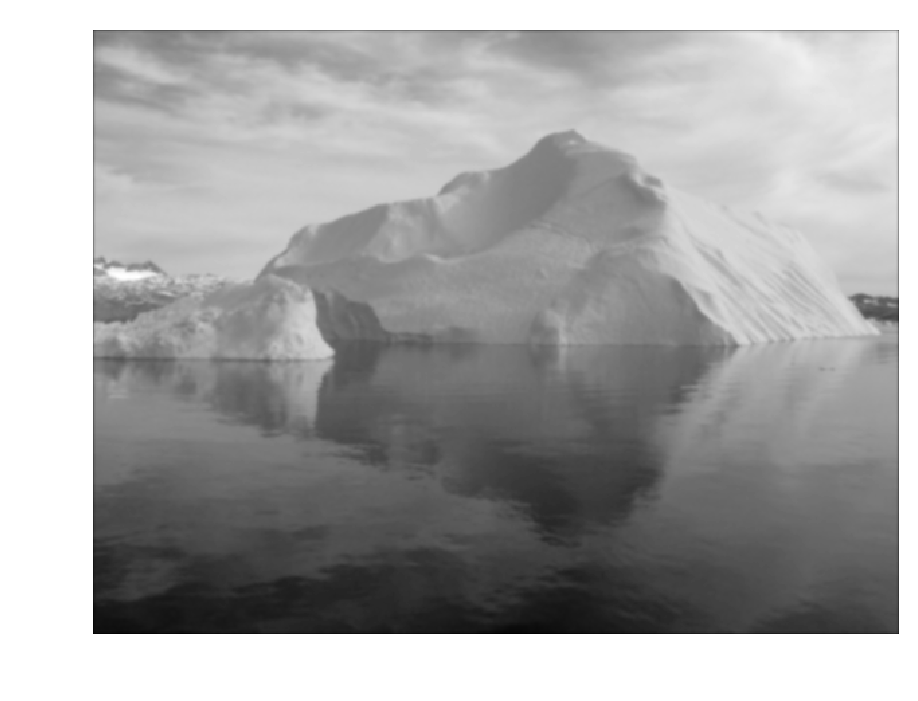

In [138]:
def eigen_image_p(lpf,Gi,scale):
    '''    
    %function [ef2,nL] = eigen_image_p(lpf,Gi)
    %set up in pyramid scheme with detection scaled smoothed images
    %ef2 is the interest point eigen image
    %lpf smoothed by the detection scale gaussian
    %Gi = fspecial('gaussian',ceil(7*sigi),sigi);
    '''
    [fy,fx] = np.gradient(lpf)

    [fxy,fxx] = np.gradient(fx)
    [fyy,fyx] = np.gradient(fy)
    nL = scale**(-2)*np.abs(fxx+fyy)

    Mfxx = convolve(np.square(fx),Gi,mode='constant')
    Mfxy = convolve(fx*fy,Gi,mode='constant')
    Mfyy = convolve(np.square(fy),Gi,mode='constant')

    Tr = Mfxx+Mfyy
    Det = Mfxx*Mfyy-np.square(Mfxy)
    sqrterm = np.sqrt(np.square(Tr)-4*Det)

    ef2 = scale**(-2)*0.5*(Tr - sqrterm)
    return ef2,nL

class ImagePyramid:
    def __init__ (self, levels, ratio, sigdec, sigint):
        self.levels = levels
        self.ratio = ratio
        self.images = []
        self.lpimages = []
        self.sigd = [sigdec]
        self.sigi = [sigint]
        self.lpfilter = fspecial_gauss(int(np.ceil(7*sigdec)),sigdec)
        # Make a note of this 7x7 gaussian kernel, lowering will speed up computation
        
    def generate_pyramid(self,img):
        self.images = [np.float64(img)]
        self.lpimages = [convolve(self.images[0],self.lpfilter,mode='constant')]
        for k in range(1,self.levels):
            #self.images += [cv2.resize(self.images[-1], (0,0), fx=self.ratio,
            #                          fy=self.ratio, interpolation=cv2.INTER_LINEAR_EXACT)]
            self.images += [imresize(self.images[-1], self.ratio, method='bilinear')]
            self.lpimages += [convolve(self.images[-1],self.lpfilter,mode='constant')]
            self.sigd += [self.sigd[-1]/self.ratio] #equivalent sigdec at max res
            self.sigi += [self.sigi[-1]/self.ratio] 

            
P = ImagePyramid(6,0.75,1,2.75)
st = time.time()
for i in range(10):
    P.generate_pyramid(gr1)
print("time: ",(time.time()-st)/10)
fig, ax1 = plt.subplots(1,1,dpi=200)
plt.axis("off")
plt.imshow(P.lpimages[1],cmap='gray')
plt.show()

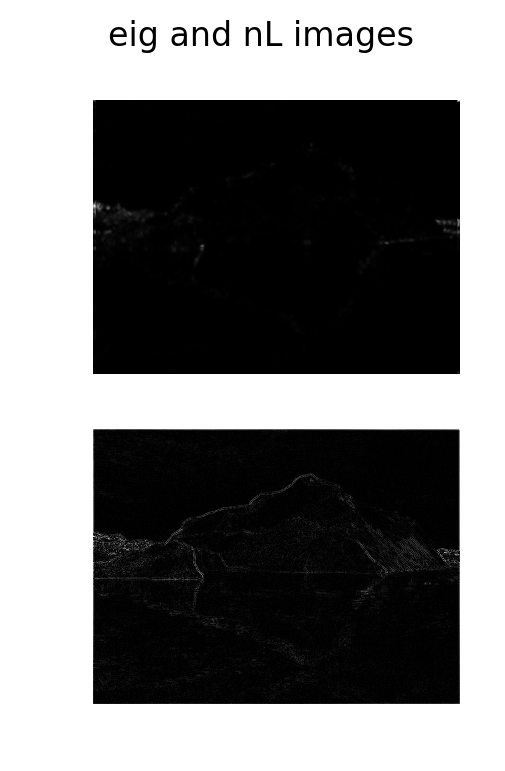

In [111]:
Gi = fspecial_gauss(11, 2.75)
lpf = P.lpimages[0]
scale = 0.75
[eig, nL] = eigen_image_p(lpf,Gi,scale)
fig, [ax1,ax2] = plt.subplots(2,1,dpi=200)
fig.suptitle('eig and nL images')
#a.axis("off")
ax1.imshow(eig,cmap='gray'),ax1.axis("off")
ax2.imshow(nL,cmap='gray'),ax2.axis("off")
plt.show()

In [139]:
def feat_extract_p2 (P, zrad, Gi):
    local_maxima_nhood=3

    scales = P.levels
    ratio = P.ratio
    #E(1).levels = scales;
    border = zrad
    [rows,cols] = P.lpimages[0].shape

    eig = [None] * scales
    nL = [None] * scales
    border_mask = [None] * scales 
    regmask=[None] * scales 
    ivec= [None] * scales 
    jvec= [None] * scales

    for k in range(scales):
        [eig[k], nL[k]] = eigen_image_p(P.lpimages[k] , Gi,ratio**(k))
        # extract regional max and block out borders (edge effect)

        # generate mask for border
        border_mask[k] = np.zeros_like(eig[k],dtype=bool)
        border_mask[k][border:-border,border:-border]=True

        #E(k).regmask = imregionalmax(E(k).eig)
        regmask[k] = maximum_filter(eig[k],size=local_maxima_nhood)<=eig[k]

        regmask[k] = np.logical_and(regmask[k],border_mask[k])
        print("K: ",k," - ",np.sum(regmask[k]))
        #[ivec[k], jvec[k]] = np.nonzero(regmask[k]) #coordinates of 1s in regmask
        # Just to match matlab version, can be reverted to optimise
        [jvec[k], ivec[k]] = np.nonzero(regmask[k].T)

    # INITIALIZE feature positions and scales at highest level
    # at highest resolution coordinates of features:
    Fivec = ivec[0]
    Fjvec = jvec[0]
    Fsvec = np.zeros_like(Fivec) #initial scale 
    Fevec = eig[0][ivec[0],jvec[0]] #access the elements of eig at locations given by ivec,jvec

    #i,j position of feature at the characteristic scale
    Fsivec = Fivec 
    Fsjvec = Fjvec

    nLvec = nL[0][ivec[0],jvec[0]]
    pivec = Fivec
    pjvec = Fjvec
    pind = np.array(list(range(len(Fivec))))
    k = 1

    while  (k < scales) & (len(pivec) > 0):
        mx = (np.floor(cols*ratio)-1)/(cols-1)  #scale conversion to next level
        my = (np.floor(rows*ratio)-1)/(rows-1) 

        [rows,cols]  = eig[k].shape #dimensions of next level
        pendreg = np.zeros_like(pivec)
        #sivec = np.round((pivec-1)*my+1).astype(int) #next scale ivec
        #sjvec = np.round((pjvec-1)*mx+1).astype(int) #next scale jvec
        # match matlab output
        sivec = np.round(pivec*my+np.finfo(np.float32).eps).astype(int) #next scale ivec
        sjvec = np.round(pjvec*mx+np.finfo(np.float32).eps).astype(int) #next scale jvec

        scipy.io.savemat('py_orig_vecs.mat', mdict={'pysivec': sivec, 'pysjvec':sjvec })

        csivec = sivec
        csjvec = sjvec
        #cloc = sivec+1 + rows*(sjvec)

        for u in range(-1,2):  #account for motion of feature points between scales
            for v in range(-1,2):

                sojvec = sjvec+u #next scale jvec

                soivec = sivec+v #next scale ivec

                #loc = soivec + rows*(sojvec-1) #index vector of next level
                #have to account for motion of feature point at different
                #scales - more than just the sampling

                uvpend = regmask[k][soivec,sojvec] == 1
                pendreg = np.logical_or(pendreg,uvpend)
                #print("u,v:",u,v," pendreg:",np.sum(pendreg))
                #cloc[uvpend] = loc[uvpend]
                #print("474: ",uvpend[473])
                csivec[uvpend] = soivec[uvpend]
                csjvec[uvpend] = sojvec[uvpend]


        pend = np.logical_and(pendreg, nL[k][csivec,csjvec] >= nLvec)

        pind = pind[pend]

        Fsvec[pind] = k #scale is k or larger
        Fevec[pind] = eig[k][csivec[pend],csjvec[pend]] #eigen value is given at
                                             #level k or larger
        Fsivec[pind] = csivec[pend]
        Fsjvec[pind] = csjvec[pend]

        pivec = csivec[pend]
        pjvec = csjvec[pend]
        nLvec = nL[k][csivec[pend],csjvec[pend]]
        print(np.sum(Fsvec==k))
        k = k+1
return Fivec,Fjvec,Fsvec,Fevec,Fsivec,Fsjvec

P = ImagePyramid(6,0.75,1,2.75)
P.generate_pyramid(gr1)
zrad = 22
Gi = fspecial_gauss(11, 2.75)

out_list = feat_extract_p2(P,zrad,Gi)


NameError: name 'Fivec' is not defined

In [143]:
def feat_extract_p2 (P, zrad, Gi):
    local_maxima_nhood=3

    scales = P.levels
    ratio = P.ratio
    #E(1).levels = scales;
    border = zrad
    [rows,cols] = P.lpimages[0].shape

    eig = [None] * scales
    nL = [None] * scales
    border_mask = [None] * scales 
    regmask=[None] * scales 
    ivec= [None] * scales 
    jvec= [None] * scales

    for k in range(scales):
        [eig[k], nL[k]] = eigen_image_p(P.lpimages[k] , Gi,ratio**(k))
        # extract regional max and block out borders (edge effect)

        # generate mask for border
        border_mask[k] = np.zeros_like(eig[k],dtype=bool)
        border_mask[k][border:-border,border:-border]=True

        #E(k).regmask = imregionalmax(E(k).eig)
        regmask[k] = maximum_filter(eig[k],size=local_maxima_nhood)<=eig[k]

        regmask[k] = np.logical_and(regmask[k],border_mask[k])
        print("K: ",k," - ",np.sum(regmask[k]))
        #[ivec[k], jvec[k]] = np.nonzero(regmask[k]) #coordinates of 1s in regmask
        # Just to match matlab version, can be reverted to optimise
        [jvec[k], ivec[k]] = np.nonzero(regmask[k].T)

    # INITIALIZE feature positions and scales at highest level
    # at highest resolution coordinates of features:
    Fivec = ivec[0]
    Fjvec = jvec[0]
    Fsvec = np.zeros_like(Fivec) #initial scale 
    Fevec = eig[0][ivec[0],jvec[0]] #access the elements of eig at locations given by ivec,jvec

    #i,j position of feature at the characteristic scale
    Fsivec = Fivec 
    Fsjvec = Fjvec

    nLvec = nL[0][ivec[0],jvec[0]]
    pivec = Fivec
    pjvec = Fjvec
    pind = np.array(list(range(len(Fivec))))
    k = 1

    while  (k < scales) & (len(pivec) > 0):
        mx = (np.floor(cols*ratio)-1)/(cols-1)  #scale conversion to next level
        my = (np.floor(rows*ratio)-1)/(rows-1) 

        [rows,cols]  = eig[k].shape #dimensions of next level
        pendreg = np.zeros_like(pivec)
        #sivec = np.round((pivec-1)*my+1).astype(int) #next scale ivec
        #sjvec = np.round((pjvec-1)*mx+1).astype(int) #next scale jvec
        # match matlab output
        sivec = np.round(pivec*my+np.finfo(np.float32).eps).astype(int) #next scale ivec
        sjvec = np.round(pjvec*mx+np.finfo(np.float32).eps).astype(int) #next scale jvec

        scipy.io.savemat('py_orig_vecs.mat', mdict={'pysivec': sivec, 'pysjvec':sjvec })

        csivec = sivec
        csjvec = sjvec
        #cloc = sivec+1 + rows*(sjvec)

        for u in range(-1,2):  #account for motion of feature points between scales
            for v in range(-1,2):

                sojvec = sjvec+u #next scale jvec

                soivec = sivec+v #next scale ivec

                #loc = soivec + rows*(sojvec-1) #index vector of next level
                #have to account for motion of feature point at different
                #scales - more than just the sampling

                uvpend = regmask[k][soivec,sojvec] == 1
                pendreg = np.logical_or(pendreg,uvpend)
                #print("u,v:",u,v," pendreg:",np.sum(pendreg))
                #cloc[uvpend] = loc[uvpend]
                #print("474: ",uvpend[473])
                csivec[uvpend] = soivec[uvpend]
                csjvec[uvpend] = sojvec[uvpend]


        pend = np.logical_and(pendreg, nL[k][csivec,csjvec] >= nLvec)

        pind = pind[pend]

        Fsvec[pind] = k #scale is k or larger
        Fevec[pind] = eig[k][csivec[pend],csjvec[pend]] #eigen value is given at
                                             #level k or larger
        Fsivec[pind] = csivec[pend]
        Fsjvec[pind] = csjvec[pend]

        pivec = csivec[pend]
        pjvec = csjvec[pend]
        nLvec = nL[k][csivec[pend],csjvec[pend]]
        print(np.sum(Fsvec==k))
        k = k+1
    return Fivec,Fjvec,Fsvec,Fevec,Fsivec,Fsjvec


In [132]:
gr1

array([[113, 118, 121, ..., 194, 194, 194],
       [120, 118, 117, ..., 193, 193, 192],
       [121, 119, 118, ..., 195, 194, 197],
       ...,
       [ 29,  30,  28, ...,  68,  69,  69],
       [ 28,  31,  28, ...,  70,  70,  71],
       [ 28,  30,  28, ...,  66,  69,  67]], dtype=uint8)

In [5]:
from skimage.transform import resize
import sys
sys.path.append('/Users/vik748/matlab_imresize/')
from imresize import imresize

b = gr1[0:10,0:10].astype(float)
c = cv2.resize(b, (0,0), fx=0.75,fy=0.75, interpolation=cv2.INTER_LINEAR)
d = resize(b,tuple(round(i * .75) for i in b.shape), order=1, mode='constant',anti_aliasing=True,anti_aliasing_sigma=0.25/2)
st = time.time()
for i in range(10):
    e = imresize(np.double(b),0.75,method='bilinear')
print ("time elapsed:", (time.time()-st)/10)
#image, output_shape, order=1, , cval=0, clip=True, preserve_range=False, anti_aliasing=True, anti_aliasing_sigma=None
e

time elapsed: 0.0004091978073120117


array([[115.7521, 118.9545, 119.9752, 120.1983, 120.8182, 120.6198,
        121.2893, 119.5455],
       [119.9545, 118.    , 118.2727, 119.2273, 119.25  , 120.1818,
        119.9091, 120.5   ],
       [116.8678, 115.4545, 115.6446, 116.3388, 117.4091, 118.3802,
        119.124 , 121.0909],
       [112.5289, 112.7273, 112.6694, 113.0661, 113.7273, 114.438 ,
        114.2893, 116.7273],
       [109.5455, 112.5   , 113.2273, 112.6818, 112.75  , 113.3182,
        113.8636, 112.5   ],
       [112.2727, 113.3182, 113.4628, 114.0331, 113.3636, 113.0661,
        112.5207, 111.    ],
       [114.281 , 115.2273, 114.281 , 115.1488, 113.6364, 112.5455,
        114.3802, 112.9091],
       [115.5455, 116.5   , 117.    , 119.7273, 117.5   , 115.8182,
        116.6364, 116.    ]])

In [71]:
import numpy, scipy.io

#arr = numpy.arange(10)
#arr = arr.reshape((3, 3))  # 2d array of 3x3

scipy.io.savemat('pyregmask.mat', mdict={'pyregmask': regmask[1]})

nL[1]

array([[28.3206, 35.0784, 31.3758, ..., 49.8939, 56.184 , 45.3643],
       [34.9591, 42.7243, 37.2436, ..., 60.2103, 69.0665, 56.2088],
       [30.2358, 36.0278, 29.6137, ..., 50.1149, 60.1003, 49.7943],
       ...,
       [ 6.7946,  8.3535,  7.2157, ..., 18.3759, 21.7445, 17.7524],
       [ 8.3606, 10.1147,  8.5496, ..., 21.8917, 24.8259, 20.0245],
       [ 7.0056,  8.4722,  7.2006, ..., 17.8888, 20.0517, 16.1508]])

In [ ]:
uvpend

In [ ]:
Fevec = eig[0](ivec[0] + rows*(jvec[0]-1)) #1D index

In [ ]:
tuple(round(i * .75) for i in b.shape)

In [ ]:
i = np.array([2,3,4,5]);
j = np.array([1,2,3,4]);

In [ ]:
a[i,j]